# Recommender Systems 2018/19

### Practice 2 - Non personalized recommenders

#### We will use the Movielens 10 million dataset. We download it and uncompress the file we need

In [1]:
from urllib.request import urlretrieve
import zipfile

In [2]:
urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", "movielens_10m.zip")

('movielens_10m.zip', <http.client.HTTPMessage at 0x4fdbb00>)

In [3]:
dataFile = zipfile.ZipFile("movielens_10m.zip")

URM_path = dataFile.extract("ml-10M100K/ratings.dat")

URM_file = open(URM_path, 'r')

In [4]:
type(URM_file)

_io.TextIOWrapper

#### Let's take a look at the data

In [5]:
for _ in range(10):
    print(URM_file.readline())

1::122::5::838985046

1::185::5::838983525

1::231::5::838983392

1::292::5::838983421

1::316::5::838983392

1::329::5::838983392

1::355::5::838984474

1::356::5::838983653

1::362::5::838984885

1::364::5::838983707



In [6]:
# Start from beginning of the file
URM_file.seek(0)
numberInteractions = 0

for _ in URM_file:
   numberInteractions += 1

print ("The number of interactions is {}".format(numberInteractions))

The number of interactions is 10000054


### We split each row to separate user, item, rating and timestamp. We do that with a custom function creating a tuple for each interaction

In [7]:
def rowSplit (rowString):
    
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = float(split[2])
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result


URM_file.seek(0)
URM_tuples = []

for line in URM_file:
   URM_tuples.append(rowSplit (line))



URM_tuples[0:10]

[(1, 122, 5.0, 838985046),
 (1, 185, 5.0, 838983525),
 (1, 231, 5.0, 838983392),
 (1, 292, 5.0, 838983421),
 (1, 316, 5.0, 838983392),
 (1, 329, 5.0, 838983392),
 (1, 355, 5.0, 838984474),
 (1, 356, 5.0, 838983653),
 (1, 362, 5.0, 838984885),
 (1, 364, 5.0, 838983707)]

### We can easily separate the four columns in different independent lists

In [8]:
userList, itemList, ratingList, timestampList = zip(*URM_tuples)

userList = list(userList)
itemList = list(itemList)
ratingList = list(ratingList)
timestampList = list(timestampList)

In [9]:
userList[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [10]:
itemList[0:10]

[122, 185, 231, 292, 316, 329, 355, 356, 362, 364]

In [11]:
ratingList[0:10]

[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]

In [12]:
timestampList[0:10]

[838985046,
 838983525,
 838983392,
 838983421,
 838983392,
 838983392,
 838984474,
 838983653,
 838984885,
 838983707]

### Now we can display some statistics

In [13]:
userList_unique = list(set(userList))
itemList_unique = list(set(itemList))

numUsers = len(userList_unique)
numItems = len(itemList_unique)


print ("Number of items\t {}, Number of users\t {}".format(numItems, numUsers))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemList_unique), max(userList_unique)))
print ("Average interactions per user {:.2f}".format(numberInteractions/numUsers))
print ("Average interactions per item {:.2f}\n".format(numberInteractions/numItems))

print ("Sparsity {:.2f} %".format((1-float(numberInteractions)/(numItems*numUsers))*100))


Number of items	 10677, Number of users	 69878
Max ID items	 65133, Max Id users	 71567

Average interactions per user 143.11
Average interactions per item 936.60

Sparsity 98.66 %


##### Rating distribution in time

In [14]:
import matplotlib.pyplot as pyplot

# Clone the list to avoid changing the ordering of the original data
timestamp_sorted = list(timestampList)
timestamp_sorted.sort()


pyplot.plot(timestamp_sorted, 'ro')
pyplot.ylabel('Timestamp ')
pyplot.xlabel('Item Index')
pyplot.show()

<Figure size 640x480 with 1 Axes>

#### To store the data we use a sparse matrix. We build it as a COO matrix and then change its format

#### The COO constructor expects (data, (row, column))

In [15]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))

URM_all

<71568x65134 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in COOrdinate format>

In [16]:
URM_all.tocsr()

<71568x65134 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in Compressed Sparse Row format>

### Item popularity

In [17]:
import numpy as np

itemPopularity = (URM_all>0).sum(axis=0)
itemPopularity

matrix([[    0, 26449, 12032, ...,     0,     0,     7]], dtype=int32)

In [18]:
itemPopularity = np.array(itemPopularity).squeeze()
itemPopularity

array([    0, 26449, 12032, ...,     0,     0,     7], dtype=int32)

In [19]:
itemPopularity = np.sort(itemPopularity)
itemPopularity

array([    0,     0,     0, ..., 33668, 34457, 34864], dtype=int32)

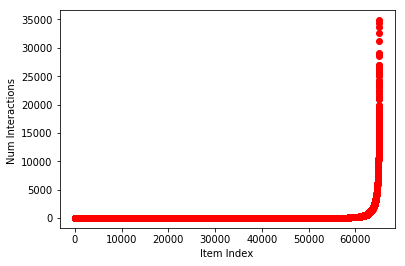

In [20]:
pyplot.plot(itemPopularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Item Index')
pyplot.show()

In [21]:
tenPercent = int(numItems/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(itemPopularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(itemPopularity[-tenPercent].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(itemPopularity[:tenPercent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(itemPopularity[int(numItems*0.45):int(numItems*0.55)].mean()))

Average per-item interactions over the whole dataset 153.53
Average per-item interactions for the top 10% popular items 2390.00
Average per-item interactions for the least 10% popular items 0.00
Average per-item interactions for the median 10% popular items 0.00


In [22]:
print("Number of items with zero interactions {}".
      format(np.sum(itemPopularity==0)))

Number of items with zero interactions 54457


In [23]:
itemPopularityNonzero = itemPopularity[itemPopularity>0]

tenPercent = int(len(itemPopularityNonzero)/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(itemPopularityNonzero.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(itemPopularityNonzero[-tenPercent].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(itemPopularityNonzero[:tenPercent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(itemPopularityNonzero[int(numItems*0.45):int(numItems*0.55)].mean()))

Average per-item interactions over the whole dataset 936.60
Average per-item interactions for the top 10% popular items 2390.00
Average per-item interactions for the least 10% popular items 5.23
Average per-item interactions for the median 10% popular items 136.45


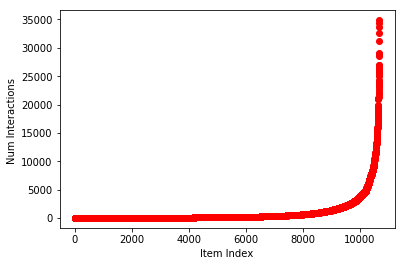

In [24]:
pyplot.plot(itemPopularityNonzero, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Item Index')
pyplot.show()

### User activity

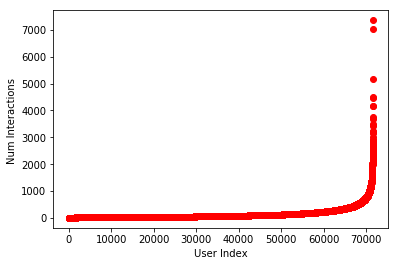

In [25]:
userActivity = (URM_all>0).sum(axis=1)
userActivity = np.array(userActivity).squeeze()
userActivity = np.sort(userActivity)


pyplot.plot(userActivity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('User Index')
pyplot.show()

### Now that we have the data, we can build our first recommender. We need two things:
* a 'fit' function to train our model
* a 'recommend' function that uses our model to recommend

### Let's start with a random recommender

#### In a random recommend we don't have anything to learn from the data

In [26]:
class RandomRecommender(object):

    def fit(self, URM_train):
           
        self.numItems = URM_train.shape[0]
    
    
    def recommend(self, user_id, at=5):
    
        recommended_items = np.random.choice(self.numItems, at)

        return recommended_items

### In order to evaluate our recommender we have to define:
* A splitting of the data in URM_train and URM_test
* An evaluation metric
* A functon computing the evaluation for each user

### The splitting of the data is very important to ensure your algorithm is evaluated in a realistic scenario by using test it has never seen.

In [27]:
train_test_split = 0.80

numInteractions = URM_all.nnz


train_mask = np.random.choice([True,False], numInteractions, p=[train_test_split, 1-train_test_split])
train_mask

array([ True,  True, False, ..., False,  True,  True])

In [28]:
userList = np.array(userList)
itemList = np.array(itemList)
ratingList = np.array(ratingList)


URM_train = sps.coo_matrix((ratingList[train_mask], (userList[train_mask], itemList[train_mask])))
URM_train = URM_train.tocsr()
URM_train

<71568x65134 sparse matrix of type '<class 'numpy.float64'>'
	with 8000726 stored elements in Compressed Sparse Row format>

In [29]:
test_mask = np.logical_not(train_mask)

URM_test = sps.coo_matrix((ratingList[test_mask], (userList[test_mask], itemList[test_mask])))
URM_test = URM_test.tocsr()
URM_test

<71568x65134 sparse matrix of type '<class 'numpy.float64'>'
	with 1999328 stored elements in Compressed Sparse Row format>

### Evaluation metric

In [30]:
user_id = userList_unique[1]
user_id

2

In [31]:
randomRecommender = RandomRecommender()
randomRecommender.fit(URM_train)

recommended_items = randomRecommender.recommend(user_id, at=5)
recommended_items

array([49922,  9348, 56204,  3919,  8319])

#### We call items in the test set 'relevant'

In [32]:
relevant_items = URM_test[user_id].indices
relevant_items

array([ 260,  719, 1073])

In [33]:
is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
is_relevant

array([False, False, False, False, False])

### Precision: how many of the recommended items are relevant

In [34]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

### Recall: how many of the relevant items I was able to recommend

In [35]:
def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

### Mean Average Precision

In [36]:
def MAP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score

### And let's test it!

In [37]:
# We pass as paramether the recommender class

def evaluate_algorithm(URM_test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0


    for user_id in userList_unique:

        relevant_items = URM_test[user_id].indices
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_MAP += MAP(recommended_items, relevant_items)


    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    print("Recommender performance is: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP)) 


In [38]:
evaluate_algorithm(URM_test, randomRecommender)

Recommender performance is: Precision = 0.0004, Recall = 0.0001, MAP = 0.0002


### So the code works. The performance however...

# Top Popular recommender

#### We recommend to all users the most popular items, that is those with the highest number of interactions
#### In this case our model is the item popularity

In [39]:
class TopPopRecommender(object):

    def fit(self, URM_train):

        itemPopularity = (URM_train>0).sum(axis=0)
        itemPopularity = np.array(itemPopularity).squeeze()

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popularItems = np.argsort(itemPopularity)
        self.popularItems = np.flip(self.popularItems, axis = 0)
    
    
    def recommend(self, user_id, at=5):
    
        recommended_items = self.popularItems[0:at]

        return recommended_items



### Now train and test our model

In [40]:
topPopRecommender = TopPopRecommender()
topPopRecommender.fit(URM_train)

In [41]:
for user_id in userList_unique[0:10]:
    print(topPopRecommender.recommend(user_id, at=5))

[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 480 318]


In [42]:
evaluate_algorithm(URM_test, topPopRecommender, at=5)

Recommender performance is: Precision = 0.0959, Recall = 0.0312, MAP = 0.0529


### That's better, but we can improve

### Hint, remove items already seen by the user

In [43]:
class TopPopRecommender(object):

    def fit(self, URM_train):
        
        self.URM_train = URM_train

        itemPopularity = (URM_train>0).sum(axis=0)
        itemPopularity = np.array(itemPopularity).squeeze()

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popularItems = np.argsort(itemPopularity)
        self.popularItems = np.flip(self.popularItems, axis = 0)
    
    
    def recommend(self, user_id, at=5, remove_seen=True):

        if remove_seen:
            unseen_items_mask = np.in1d(self.popularItems, self.URM_train[user_id].indices,
                                        assume_unique=True, invert = True)

            unseen_items = self.popularItems[unseen_items_mask]

            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popularItems[0:at]
            

        return recommended_items


In [44]:
topPopRecommender_removeSeen = TopPopRecommender()
topPopRecommender_removeSeen.fit(URM_train)

for user_id in userList_unique[0:10]:
    print(topPopRecommender_removeSeen.recommend(user_id, at=5))

[296 593 318 457 110]
[296 356 593 480 318]
[296 356 593 480 318]
[296 356 593 318 457]
[296 356 480 318 589]
[296 356 593 480 318]
[296 356 480 318 589]
[296 356 318 110 150]
[296 356 593 480 318]
[296 480 318 589 110]


In [45]:
evaluate_algorithm(URM_test, topPopRecommender_removeSeen)

Recommender performance is: Precision = 0.1988, Recall = 0.0536, MAP = 0.1475


#### Simple but effective. Always remove seen items if your purpose is to recommend "new" ones

# Global effects recommender

#### We recommend to all users the highest rated items

#### First we compute the average of all ratings, or global average

In [46]:
globalAverage = np.mean(URM_train.data)

print("The global average is {:.2f}".format(globalAverage))

The global average is 3.51


#### We subtract the bias to all ratings

In [47]:
URM_train_unbiased = URM_train.copy()

URM_train_unbiased.data -= globalAverage

print(URM_train_unbiased.data[0:10])

[1.4879161 1.4879161 1.4879161 1.4879161 1.4879161 1.4879161 1.4879161
 1.4879161 1.4879161 1.4879161]


#### Then we compute the average rating for each item, or itemBias

In [48]:
item_mean_rating = URM_train_unbiased.mean(axis=0)
item_mean_rating

matrix([[ 0.00000000e+00,  1.23224992e-01, -4.04573633e-02, ...,
          0.00000000e+00,  0.00000000e+00, -1.01307037e-06]])

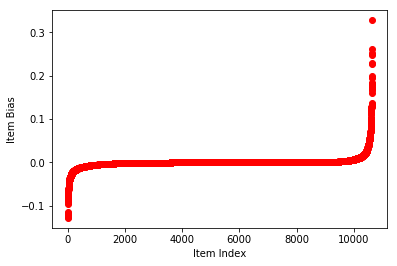

In [49]:
item_mean_rating = np.array(item_mean_rating).squeeze()
item_mean_rating = np.sort(item_mean_rating[item_mean_rating!=0])

pyplot.plot(item_mean_rating, 'ro')
pyplot.ylabel('Item Bias')
pyplot.xlabel('Item Index')
pyplot.show()

#### And the average rating for each user, or userBias

In [50]:
user_mean_rating = URM_train_unbiased.mean(axis=1)
user_mean_rating

matrix([[ 0.        ],
        [ 0.00041119],
        [-0.00010295],
        ...,
        [ 0.00067611],
        [ 0.00017644],
        [-0.00021524]])

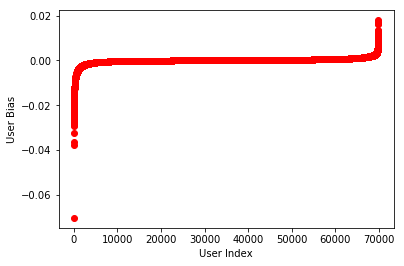

In [51]:
user_mean_rating = np.array(user_mean_rating).squeeze()
user_mean_rating = np.sort(user_mean_rating[user_mean_rating!=0.0])

pyplot.plot(user_mean_rating, 'ro')
pyplot.ylabel('User Bias')
pyplot.xlabel('User Index')
pyplot.show()

#### Now we can sort the items by their itemBias and use the same recommendation principle as in TopPop

In [52]:
class GlobalEffectsRecommender(object):

    def fit(self, URM_train):
        
        self.URM_train = URM_train

        globalAverage = np.mean(URM_train.data)

        URM_train_unbiased = URM_train.copy()
        URM_train_unbiased.data -= globalAverage

        item_mean_rating = URM_train_unbiased.mean(axis=0)
        item_mean_rating = np.array(item_mean_rating).squeeze()

        self.bestRatedItems = np.argsort(item_mean_rating)
        self.bestRatedItems = np.flip(self.bestRatedItems, axis = 0)

        
    
    def recommend(self, user_id, at=5, remove_seen=True):

        if remove_seen:

            unseen_items_mask = np.in1d(self.bestRatedItems, URM_train[user_id].indices,
                                        assume_unique=True, invert = True)

            unseen_items = self.bestRatedItems[unseen_items_mask]

            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.bestRatedItems[0:at]
            

        return recommended_items



In [53]:
globalEffectsRecommender = GlobalEffectsRecommender()
globalEffectsRecommender.fit(URM_train)

evaluate_algorithm(URM_test, globalEffectsRecommender)

Recommender performance is: Precision = 0.1688, Recall = 0.0391, MAP = 0.1226


### Now let's try to combine User bias an item bias

In [54]:
class GlobalEffectsRecommender(object):

    def fit(self, URM_train):
        
        self.URM_train = URM_train

        globalAverage = np.mean(URM_train.data)

        URM_train_unbiased = URM_train.copy()
        URM_train_unbiased.data -= globalAverage
        
        # User Bias
        user_mean_rating = URM_train_unbiased.mean(axis=1)
        user_mean_rating = np.array(user_mean_rating).squeeze()
        
        # In order to apply the user bias we have to change the rating value 
        # in the URM_train_unbiased inner data structures
        # If we were to write:
        # URM_train_unbiased[user_id].data -= user_mean_rating[user_id]
        # we would change the value of a new matrix with no effect on the original data structure
        for user_id in range(len(user_mean_rating)):
            start_position = URM_train_unbiased.indptr[user_id]
            end_position = URM_train_unbiased.indptr[user_id+1]
            
            URM_train_unbiased.data[start_position:end_position] -= user_mean_rating[user_id]

        # Item Bias
        item_mean_rating = URM_train_unbiased.mean(axis=0)
        item_mean_rating = np.array(item_mean_rating).squeeze()

        self.bestRatedItems = np.argsort(item_mean_rating)
        self.bestRatedItems = np.flip(self.bestRatedItems, axis = 0)

        
    
    def recommend(self, user_id, at=5, remove_seen=True):

        if remove_seen:

            unseen_items_mask = np.in1d(self.bestRatedItems, URM_train[user_id].indices,
                                        assume_unique=True, invert = True)

            unseen_items = self.bestRatedItems[unseen_items_mask]

            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.bestRatedItems[0:at]
            

        return recommended_items


In [55]:
globalEffectsRecommender = GlobalEffectsRecommender()
globalEffectsRecommender.fit(URM_train)

evaluate_algorithm(URM_test, globalEffectsRecommender)

Recommender performance is: Precision = 0.1688, Recall = 0.0391, MAP = 0.1226


#### The result is identical. User bias is essential in case of rating prediction but not relevant in case of TopK recommendations.

## Question:

#### Why is GlobalEffect performing worse than TopPop even if we are taking into account more information about the interaction?
.

.

.

.

.

.

.

.

.

### The test data contains a lot of low rating interactions... We are testing against those as well, but GlobalEffects is penalizing interactions with low rating

In [56]:
URM_test.data[URM_test.data<=2]

array([2., 2., 2., ..., 1., 2., 1.])

### In reality we want to recommend items rated in a positive way, so let's build a new Test set with positive interactions only

In [57]:
URM_test_positiveOnly = URM_test.copy()

URM_test_positiveOnly.data[URM_test.data<=2] = 0
URM_test_positiveOnly.eliminate_zeros()
URM_test_positiveOnly

<71568x65134 sparse matrix of type '<class 'numpy.float64'>'
	with 1722891 stored elements in Compressed Sparse Row format>

In [58]:
print("Deleted {} negative interactions".format(URM_test.nnz - URM_test_positiveOnly.nnz))

Deleted 276437 negative interactions


#### Run the evaluation again for both

In [59]:
evaluate_algorithm(URM_test_positiveOnly, topPopRecommender_removeSeen)

Recommender performance is: Precision = 0.1888, Recall = 0.0572, MAP = 0.1389


In [60]:
evaluate_algorithm(URM_test_positiveOnly, globalEffectsRecommender)

Recommender performance is: Precision = 0.1627, Recall = 0.0423, MAP = 0.1183


### GlobalEffects performs worse again...

### Ideas?

.

.

.

.

.

.

.

.

.

### Sometimes ratings are not really more informative than interactions, depends on their quality

#### Take-home message: how you build your splitting and the task you are building the algorithm for are tightly interlinked